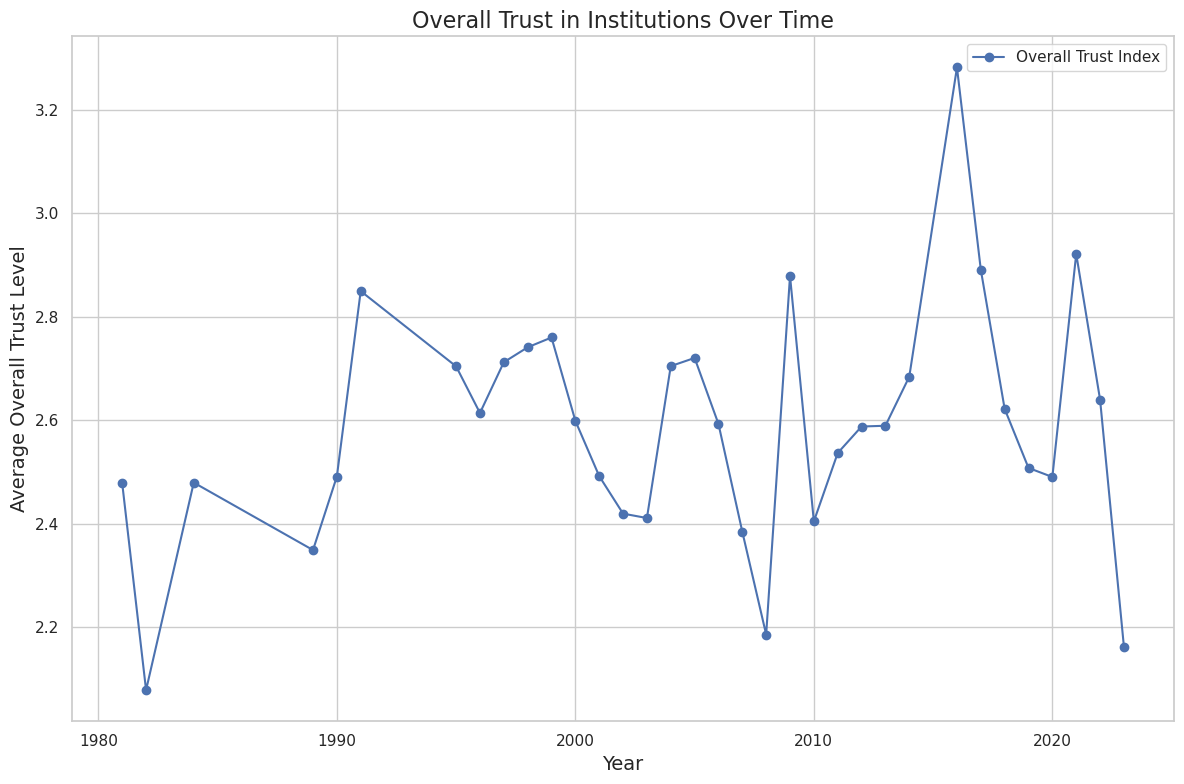

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the Dataset
file_path = "data/preprocessed/filtered_time_series_1981_2022.csv"

df = pd.read_csv(file_path, low_memory=False)

# 2. Handle Missing Values
# Replace coded missing values with NaN
missing_values = [-1, -2, -4, -5]
df.replace(missing_values, np.nan, inplace=True)

# 3. Select Relevant Columns
# Trust-related variables and survey year
# 1. Calculate an Overall Trust Index
# Select confidence-related columns
confidence_columns = [
    "C Police", "C Parliament", "C Civil Services",
    "C Television", "C Government", "C Political Parties", "C Courts"
]

# Create a new column for the overall trust index (average of all "C" columns)
df["Overall_Trust"] = df[confidence_columns].mean(axis=1, skipna=True)

# 2. Group by Survey Year to calculate the yearly average trust index
trust_index_trends = df.groupby("Survey year")["Overall_Trust"].mean().reset_index()

# 3. Visualize the Overall Trust Index over Time
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
plt.plot(trust_index_trends["Survey year"], trust_index_trends["Overall_Trust"], marker='o', label="Overall Trust Index")

# Customize the plot
plt.title("Overall Trust in Institutions Over Time", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Average Overall Trust Level", fontsize=14)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


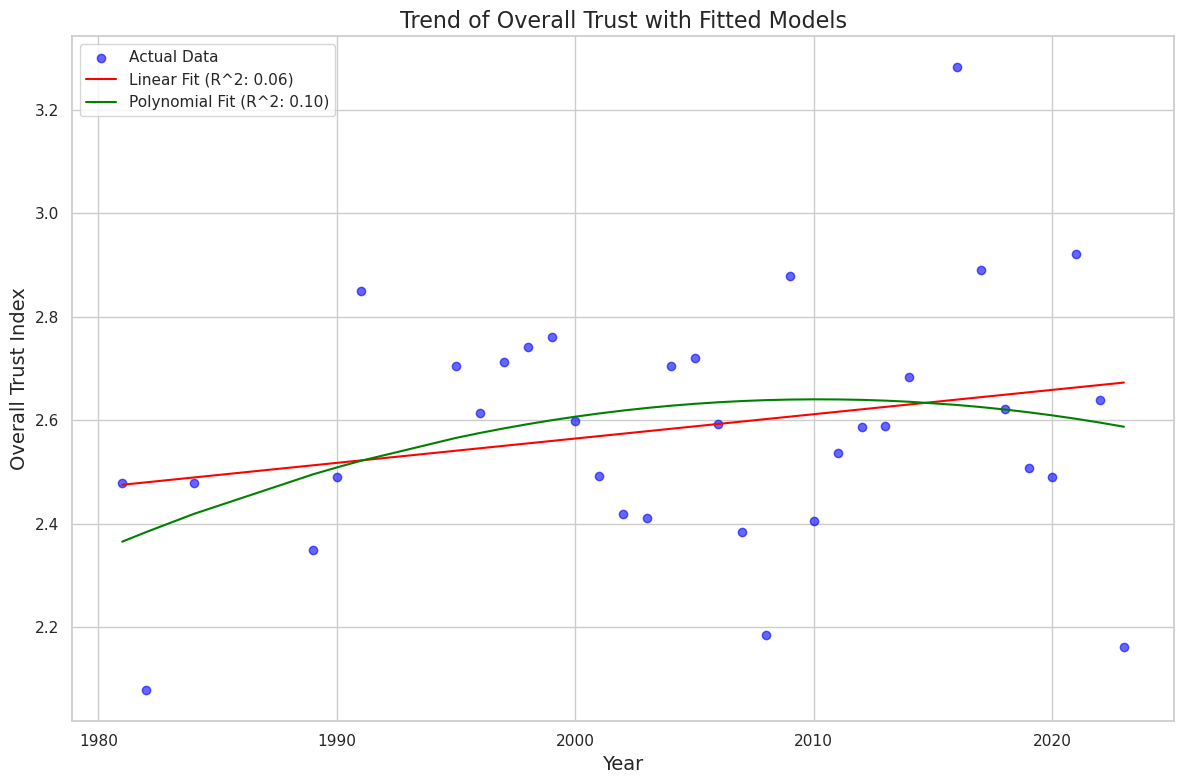

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import numpy as np

# Prepare data
X = trust_index_trends["Survey year"].values.reshape(-1, 1)
y = trust_index_trends["Overall_Trust"]

# Fit a Linear Regression Model
linear_model = LinearRegression()
linear_model.fit(X, y)
y_pred_linear = linear_model.predict(X)

# Fit a Polynomial Regression Model (degree=2)
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

poly_model = LinearRegression()
poly_model.fit(X_poly, y)
y_pred_poly = poly_model.predict(X_poly)

# Plot the trends
plt.figure(figsize=(12, 8))
plt.scatter(X, y, color="blue", label="Actual Data", alpha=0.6)
plt.plot(X, y_pred_linear, color="red", label="Linear Fit (R^2: {:.2f})".format(linear_model.score(X, y)))
plt.plot(X, y_pred_poly, color="green", label="Polynomial Fit (R^2: {:.2f})".format(poly_model.score(X_poly, y)))

# Customize plot
plt.title("Trend of Overall Trust with Fitted Models", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Overall Trust Index", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()


In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv("data/preprocessed/filtered_time_series_1981_2022.csv", low_memory=False)

# Replace coded missing values with NaN
df.replace([-1, -2, -4, -5], np.nan, inplace=True)

# Create Overall Trust Index (average of C = Confidence variables)
confidence_cols = [
    "C Police", "C Parliament", "C Civil Services",
    "C Television", "C Government", "C Political Parties", "C Courts"
]
df["Overall_Trust_Index"] = df[confidence_cols].mean(axis=1)

# Drop rows with missing Overall Trust Index or key columns
df.dropna(subset=["Overall_Trust_Index", "Country", "Survey year"], inplace=True)

# Convert Year and Country into categorical variables
df["Survey year"] = df["Survey year"].astype(int)  # Ensure year is numeric
df["Country"] = df["Country"].astype(str)          # Convert country to string

# Collapse trust levels into ordinal categories (optional)
df["Overall_Trust_Ordinal"] = pd.cut(
    df["Overall_Trust_Index"],
    bins=[1, 2, 3, 4],
    labels=[1, 2, 3],
    include_lowest=True
).astype(int)

# Encode categorical variables
encoder = LabelEncoder()
df["Country_encoded"] = encoder.fit_transform(df["Country"])


In [23]:
import pandas as pd
import numpy as np
from statsmodels.miscmodels.ordinal_model import OrderedModel

# Load your data
df = pd.read_csv("data/preprocessed/filtered_wave_7.csv", low_memory=False)

# Replace coded missing values with NaN
df.replace([-1, -2, -4, -5], np.nan, inplace=True)

# Define the confidence-related columns based on your dataset
confidence_cols = [
    "C Armed forces", "C Police", "C Courts", "C Government",
    "C Political parties", "C Civil services", "C Television", "C Elections"
]

# Create Overall Trust Index
df["Overall_Trust_Index"] = df[confidence_cols].mean(axis=1)

# Drop rows with missing or infinite values in predictors and target
df.dropna(subset=["Overall_Trust_Index", "Age", "Scale of incomes", "Highest educational level"], inplace=True)

# Convert `Overall_Trust_Index` to ordinal categories
df["Overall_Trust_Ordinal"] = pd.cut(
    df["Overall_Trust_Index"],
    bins=[1, 2, 3, 4],
    labels=[1, 2, 3],
    include_lowest=True
).astype(int)

# Prepare the predictors (X) and target (y)
X = df[["Age", "Scale of incomes", "Highest educational level"]].astype(float)
y = df["Overall_Trust_Ordinal"]

# Ensure no missing or infinite values in X
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)

# Align X and y
y = y.loc[X.index]

# Fit the cumulative link model
model = OrderedModel(
    endog=y,
    exog=X,
    distr="logit"  # Cumulative logit model
)
results = model.fit(method="bfgs", maxiter=100)
print(results.summary())

# Extract predicted probabilities
pred_probs = results.predict(X)
print("\nPredicted probabilities for each category:")
print(pred_probs.head())


Optimization terminated successfully.
         Current function value: 1.012541
         Iterations: 11
         Function evaluations: 16
         Gradient evaluations: 16
                               OrderedModel Results                              
Dep. Variable:     Overall_Trust_Ordinal   Log-Likelihood:                -94148.
Model:                      OrderedModel   AIC:                         1.883e+05
Method:               Maximum Likelihood   BIC:                         1.884e+05
Date:                   Mon, 27 Jan 2025                                         
Time:                           17:10:31                                         
No. Observations:                  92982                                         
Df Residuals:                      92977                                         
Df Model:                              3                                         
                                coef    std err          z      P>|z|      [0.025      0.9

In [21]:
print(df.columns.tolist())


['Country', 'Year', 'C Armed forces', 'C Television', 'C Police', 'C Courts', 'C Government', 'C Political parties', 'C Civil services', 'C Elections', 'Importance of democracy', 'Highest educational level', 'Age', 'Scale of incomes', 'Sex', 'Strong Leader', 'Expert Non Govt Person', 'Signing a petition', 'Joining unofficial strikes']


Accuracy: 0.2577
Log-Loss: 1.0125

Classification Report:
              precision    recall  f1-score   support

           1       0.26      1.00      0.41     23957
           2       0.00      0.00      0.00     49146
           3       0.00      0.00      0.00     19879

    accuracy                           0.26     92982
   macro avg       0.09      0.33      0.14     92982
weighted avg       0.07      0.26      0.11     92982


Confusion Matrix:


/home/rajubuntu/anaconda3/envs/WVS/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rajubuntu/anaconda3/envs/WVS/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rajubuntu/anaconda3/envs/WVS/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

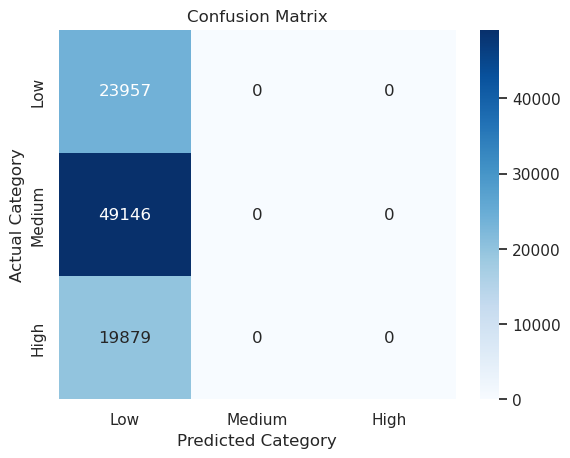

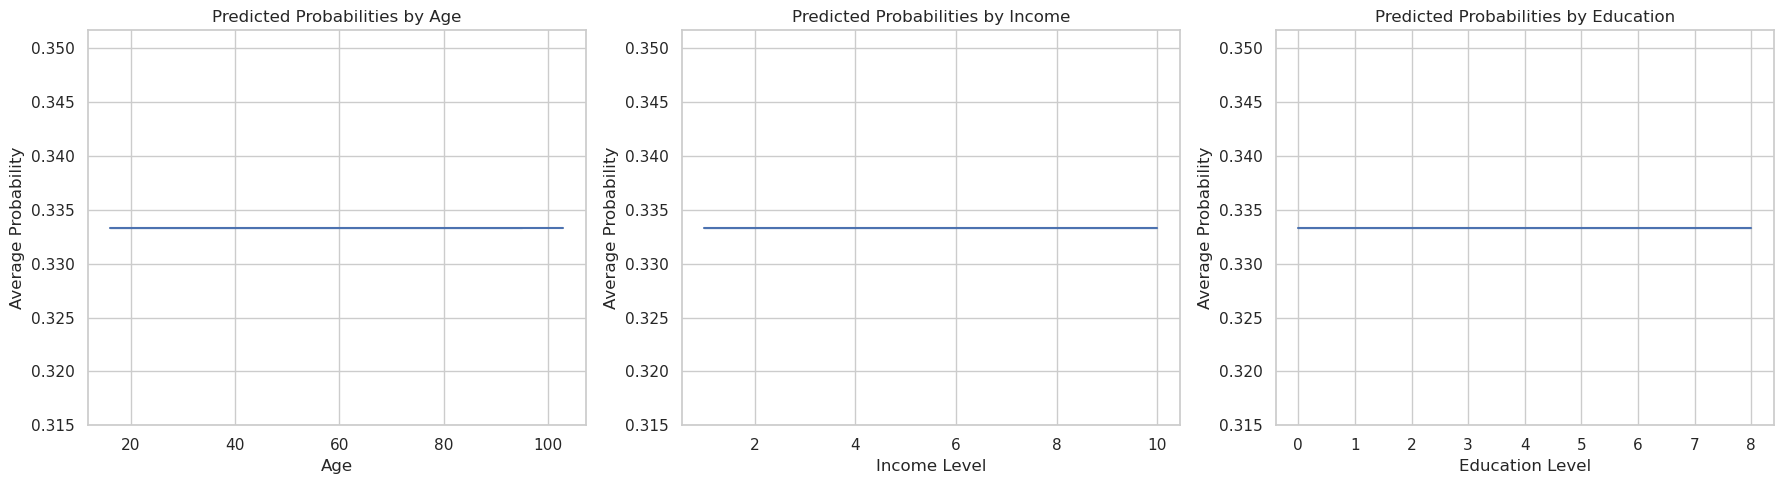

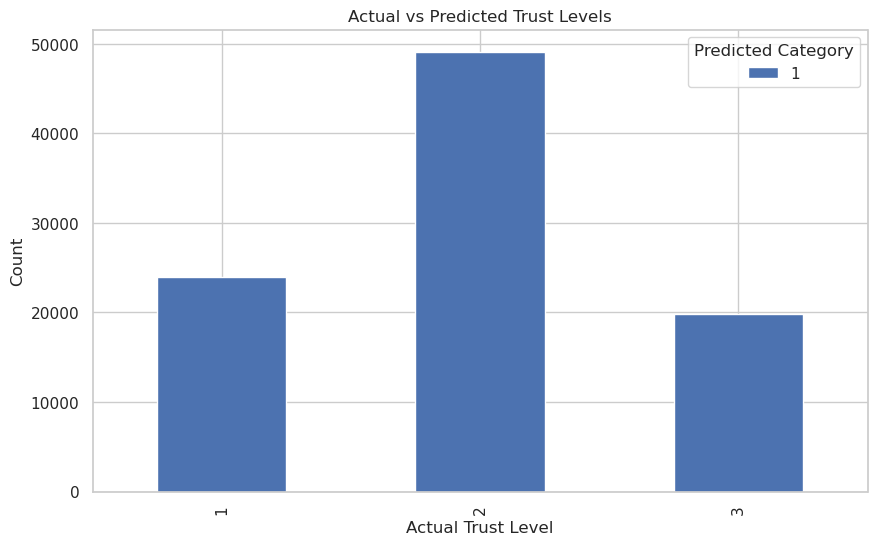

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, log_loss, classification_report, confusion_matrix

# Step 1: Convert predicted probabilities into predicted categories
y_pred = pred_probs.idxmax(axis=1)

# Step 2: Validation Metrics
# Accuracy
accuracy = accuracy_score(y, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Log-Loss
log_loss_value = log_loss(y, pred_probs)
print(f"Log-Loss: {log_loss_value:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Low", "Medium", "High"], yticklabels=["Low", "Medium", "High"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Category")
plt.ylabel("Actual Category")
plt.show()

# Step 3: Visualize Predicted Probabilities by Age, Income, and Education
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Predicted Probabilities by Age
sns.lineplot(data=pred_probs, x=df["Age"], y=pred_probs.mean(axis=1), ax=axes[0])
axes[0].set_title("Predicted Probabilities by Age")
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Average Probability")

# Predicted Probabilities by Scale of Incomes
sns.lineplot(data=pred_probs, x=df["Scale of incomes"], y=pred_probs.mean(axis=1), ax=axes[1])
axes[1].set_title("Predicted Probabilities by Income")
axes[1].set_xlabel("Income Level")
axes[1].set_ylabel("Average Probability")

# Predicted Probabilities by Education Level
sns.lineplot(data=pred_probs, x=df["Highest educational level"], y=pred_probs.mean(axis=1), ax=axes[2])
axes[2].set_title("Predicted Probabilities by Education")
axes[2].set_xlabel("Education Level")
axes[2].set_ylabel("Average Probability")

plt.tight_layout()
plt.show()

# Step 4: Compare Actual and Predicted Categories
df["Predicted_Category"] = y_pred
actual_vs_predicted = df.groupby(["Overall_Trust_Ordinal", "Predicted_Category"]).size().unstack(fill_value=0)

# Plot Comparison
actual_vs_predicted.plot(kind="bar", stacked=True, figsize=(10, 6))
plt.title("Actual vs Predicted Trust Levels")
plt.xlabel("Actual Trust Level")
plt.ylabel("Count")
plt.legend(title="Predicted Category")
plt.show()


In [30]:
import pandas as pd
import numpy as np
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Merge Trust Variables into a Composite Index
trust_variables = [
    "C Armed forces", "C Television", "C Police", "C Courts", "C Government",
    "C Political parties", "C Civil services", "C Elections"
]
df["Overall_Trust_Index"] = df[trust_variables].mean(axis=1)

# 2. Create Ordinal Categories for Overall Trust Index
# Define thresholds for categories (e.g., low, medium, high trust)
df["Overall_Trust_Ordinal"] = pd.cut(
    df["Overall_Trust_Index"],
    bins=[0, 2.5, 3.5, 5],  # Adjust based on the scale of the trust variables
    labels=[0, 1, 2],  # 0: Low, 1: Medium, 2: High
    include_lowest=True
)

# Drop rows with missing values in relevant columns
df.dropna(subset=["Overall_Trust_Index", "Overall_Trust_Ordinal", "Age", "Scale of incomes", "Highest educational level"], inplace=True)

# 3. Prepare Data for Model Training
X = df[["Age", "Scale of incomes", "Highest educational level"]]
y = df["Overall_Trust_Ordinal"].astype(int)

# 4. Fit an Ordinal Logistic Regression Model
model = OrderedModel(
    endog=y,
    exog=X,
    distr="logit"  # Cumulative logit model
)
results = model.fit(method="bfgs", maxiter=100)

# Print Model Summary
print(results.summary())

# 5. Predicted Probabilities and Categories
pred_probs = results.predict(X, which="prob")  # Predicted probabilities
y_pred = pred_probs.idxmax(axis=1)  # Convert probabilities to categories

# 6. Evaluate Model Performance
print("\nAccuracy:", accuracy_score(y, y_pred))
print("\nClassification Report:")
print(classification_report(y, y_pred))

# 7. Confusion Matrix
conf_matrix = confusion_matrix(y, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Low", "Medium", "High"], yticklabels=["Low", "Medium", "High"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Category")
plt.ylabel("Actual Category")
plt.show()


KeyError: "['C Armed forces', 'C Political parties', 'C Civil services'] not in index"

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# 1. Load the Dataset
file_path = "data/preprocessed/filtered_time_series_1981_2022.csv"
df = pd.read_csv(file_path)

# 2. Data Cleaning and Preparation
confidence_cols = [
    "C Television", "C Police", "C Courts",
    "C Government", "C Political Parties", "C Civil Services", "C Elections"
]
df.columns = df.columns.str.strip().str.replace(" ", "_")
df.replace([-1, -2, -4, -5], np.nan, inplace=True)

# Impute Missing Values
for col in confidence_cols:
    df[col].fillna(df[col].median(), inplace=True)  # Fill numeric columns with median

df["Age"].fillna(df["Age"].median(), inplace=True)
df["Scale_of_incomes"].fillna(df["Scale_of_incomes"].median(), inplace=True)
df["Highest_educational_level"].fillna(df["Highest_educational_level"].median(), inplace=True)

# Debugging: Check missing values after imputation
print("Missing values after imputation:")
print(df.isnull().sum())

# Create Overall Trust Index
df["Overall_Trust_Index"] = df[confidence_cols].mean(axis=1)

# 3. Create Ordinal Categories for Overall Trust Index
df["Overall_Trust_Ordinal"] = pd.cut(
    df["Overall_Trust_Index"],
    bins=[0, 2.5, 3.5, 5],  # Adjust based on the scale of the trust variables
    labels=[0, 1, 2],  # 0: Low, 1: Medium, 2: High
    include_lowest=True
)

# Drop rows with missing values in predictors and target
df.dropna(subset=["Overall_Trust_Index", "Overall_Trust_Ordinal", "Age", "Scale_of_incomes", "Highest_educational_level"], inplace=True)

# Debugging: Check the remaining rows
print(f"Number of rows after cleaning: {df.shape[0]}")

# 4. Define Features and Target
X = df[["Age", "Scale_of_incomes", "Highest_educational_level"]]
y = df["Overall_Trust_Ordinal"].astype(int)

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

# Debugging: Check the shape after SMOTE
print(f"Shape of X_balanced: {X_balanced.shape}")
print(f"Shape of y_balanced: {y_balanced.shape}")

# 6. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# 7. Fit the Ordered Model
model = OrderedModel(
    endog=y_train,
    exog=X_train,
    distr="logit"  # Cumulative logit model
)
results = model.fit(method="bfgs", maxiter=100)
print(results.summary())

# 8. Predictions and Validation
y_pred_probs = results.predict(exog=X_test, which="prob")
y_pred = y_pred_probs.idxmax(axis=1)

# Evaluation Metrics
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy:", accuracy_score(y_test, y_pred))

# 9. Visualize Time Series Trend of Trust Index
time_series = df.groupby("Survey_year")["Overall_Trust_Index"].mean()

plt.figure(figsize=(12, 6))
plt.plot(time_series.index, time_series.values, marker="o", label="Overall Trust Index")
plt.title("Overall Trust Index Over Time")
plt.xlabel("Year")
plt.ylabel("Trust Index")
plt.legend()
plt.grid(True)
plt.show()

# 10. Time Series Decomposition
time_series = time_series.asfreq('YS', method='pad')  # Ensure regular frequency for decomposition
decomposition = seasonal_decompose(time_series, model="additive")

# Plot Decomposition
decomposition.plot()
plt.tight_layout()
plt.show()


KeyError: 'C Television'